# Visualizing EEG Data using MNE


#### Authors: 
- Dr. Rahul Remanan <rahul@moad.computer>
- Brian Parbhu
- Martin Luessi <mluessi@nmr.mgh.harvard.edu>
- Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
- Nicolas P. Rougier (graph code borrowed from his matplotlib gallery)
- Clemens Bruner - (borowed examples from his blog)

#### Install dependencies

In [1]:
%matplotlib notebook

In [2]:
setup = False
set_trace = False
if setup:
    !pip3 install mne
    !pip3 install PyQt5
    !pip3 install PySide2
    !pip3 install scikit-learn
    !pip3 install scipy
    !pip3 install wget

**Import dependencies**

In [3]:
from scipy.io import loadmat
import wget
from datetime import date
import numpy as np
import ipdb

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [6]:
import mne
from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

## Part 01 -- Visualization of EEG Channels

**Here's an example of how EEG channels are displayed in the 10-20 system**

> Here we will showcase the different channel positions within the 10-20 system.



In [7]:
# We need to load our subject data
# If you want to supress the output log of download info use this line
mne.set_log_level("WARNING")
subject = 4
runs = [4, 8 ,12]
raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in
             raw_fnames]
raw = concatenate_raws(raw_files)

# Let's print some metadata about our subject data
print(raw)
print(raw.info)

<RawEDF  |  S004R04.edf, n_channels x n_times : 65 x 59040 (369.0 sec), ~29.4 MB, data loaded>
<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., ...
    chs : list | 65 items (EEG: 64, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 80.0 Hz
    meas_date : int | 1250093700
    nchan : int | 65
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq

In [8]:
# You can index metadata about your dataset you want to 
# look via dictionary indexing
print(raw.info["sfreq"])

160.0


**Here's how to print out some descriptive aspects of our data**

*  "bads" - List of bad channels (is empty when starting out)
*   "ch_names" - List of the Channel names
*  " chs" - Channel Properties
*  "highpass" - Highpass edge frequencies used during the recordings
* "lowpass" - Lowpass edge frequencies used during the recordings
*   "meas_date" - A timestamp of the recording date







In [9]:
# Already marked bad channels
print("Bad Channels")
print(raw.info["bads"])

# Channel names
print("Channel names")
print(raw.info["ch_names"])

# Channel properties
print("Channel properties")
print(raw.info["chs"])

# Highpass edge frequencies
print("Highpass frquencies")
print(raw.info["highpass"])

# Lowpass edge frequencies
print("Lowpass frequencies")
print(raw.info["lowpass"])

# Timestamp of the EEG recording- you need to 
# convert the date to a human readable one
print("EEG Timestamp of Recording")
print(date.fromtimestamp(raw.info["meas_date"]))

Bad Channels
[]
Channel names
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..', 'STI 014']
Channel properties
[{'cal': 16184.0, 'logno': 1, 'scanno': 1, 'range': 16184.0, 'unit_mul': 0.0, 'ch_name': 'Fc5.', 'unit': 107, 'coord_frame': 4, 'coil_type': 1, 'kind': 2, 'loc': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'cal': 16184.0, 'logno': 2, 'scanno': 2, 'range': 16184.0, 'unit_mul': 0.0, 'ch_name': 'Fc3.', 'unit': 107, 'coord_frame': 4, 'coil_type': 1, 'kind': 2, 'loc': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

**Here's an example of how to rename Channels**

In [10]:
# We are printing out the first 10 channels
raw.info["ch_names"][:10]

['Fc5.',
 'Fc3.',
 'Fc1.',
 'Fcz.',
 'Fc2.',
 'Fc4.',
 'Fc6.',
 'C5..',
 'C3..',
 'C1..']

In [11]:
# Here we are going rename the channels because we don't want .. in the names
raw.rename_channels(lambda s: s.strip("."))
print(raw.info["ch_names"][:10])

['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1']


**Here we are actually going to get a set of montages of coordinate systems that are
relevant to our dataset**



---


*    **Note**: This will also depend on your EEG system as well
* **Also if you're using the 10-10 system you can use the 10-20 system montage as all the channels for the 10-10 system are present**



In [12]:
# Let's get the montages available to us
mne.channels.get_builtin_montages()

['EGI_256',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'biosemi128',
 'biosemi16',
 'biosemi160',
 'biosemi256',
 'biosemi32',
 'biosemi64',
 'easycap-M1',
 'easycap-M10',
 'mgh60',
 'mgh70',
 'standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed']

<IPython.core.display.Javascript object>


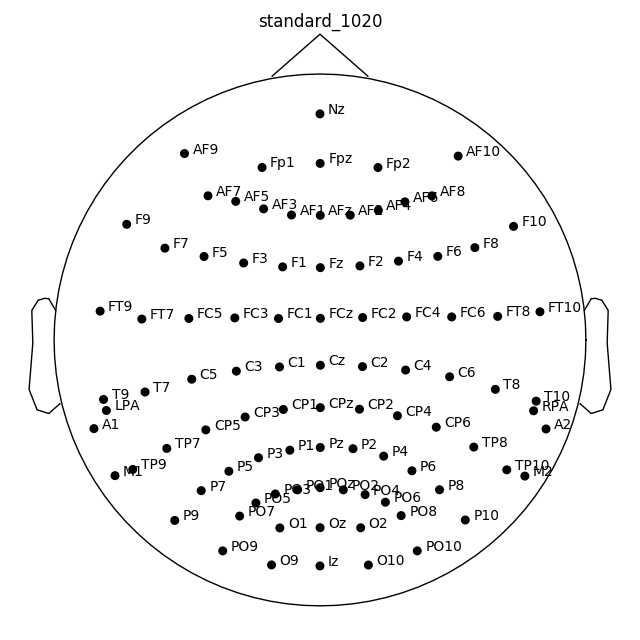

<RawEDF  |  S004R04.edf, n_channels x n_times : 65 x 59040 (369.0 sec), ~29.4 MB, data loaded>

In [13]:
# Let's pick our montage!
montage = mne.channels.read_montage("standard_1020")
montage.plot()
raw.set_montage(montage)

**Here's also how we determine reference channels in this case**

In [14]:
# Here we want the reference channel to be 
# the average of all referenced channels
raw.set_eeg_reference("average", projection=False)

<RawEDF  |  S004R04.edf, n_channels x n_times : 65 x 59040 (369.0 sec), ~29.4 MB, data loaded>

**In looking at EEG channels we're also going to be extracting events from channels**

In [15]:
events = mne.find_events(raw, initial_event=True) 
print(events)
# Values with 2 or 3 are associated with motor imagery onset 
#and 1 is considered to be at rest

[[    0     0     1]
 [  656     0     2]
 [ 1312     0     1]
 [ 1968     0     3]
 [ 2624     0     1]
 [ 3280     0     2]
 [ 3936     0     1]
 [ 4592     0     3]
 [ 5248     0     1]
 [ 5904     0     2]
 [ 6560     0     1]
 [ 7216     0     3]
 [ 7872     0     1]
 [ 8528     0     3]
 [ 9184     0     1]
 [ 9840     0     2]
 [10496     0     1]
 [11152     0     3]
 [11808     0     1]
 [12464     0     2]
 [13120     0     1]
 [13776     0     2]
 [14432     0     1]
 [15088     0     3]
 [15744     0     1]
 [16400     0     3]
 [17056     0     1]
 [17712     0     2]
 [18368     0     1]
 [19024     0     2]
 [19680     0     1]
 [20336     0     2]
 [20992     0     1]
 [21648     0     3]
 [22304     0     1]
 [22960     0     3]
 [23616     0     1]
 [24272     0     2]
 [24928     0     1]
 [25584     0     3]
 [26240     0     1]
 [26896     0     2]
 [27552     0     1]
 [28208     0     2]
 [28864     0     1]
 [29520     0     3]
 [30176     0     1]
 [30832     0

In [16]:
# Way to find annotations automatically with edf files
raw.find_edf_events()

[[0.0, 4.1, 'T0'],
 [4.1, 4.1, 'T1'],
 [8.2, 4.1, 'T0'],
 [12.3, 4.1, 'T2'],
 [16.4, 4.1, 'T0'],
 [20.5, 4.1, 'T1'],
 [24.6, 4.1, 'T0'],
 [28.7, 4.1, 'T2'],
 [32.8, 4.1, 'T0'],
 [36.9, 4.1, 'T1'],
 [41.0, 4.1, 'T0'],
 [45.1, 4.1, 'T2'],
 [49.2, 4.1, 'T0'],
 [53.3, 4.1, 'T2'],
 [57.4, 4.1, 'T0'],
 [61.5, 4.1, 'T1'],
 [65.6, 4.1, 'T0'],
 [69.7, 4.1, 'T2'],
 [73.8, 4.1, 'T0'],
 [77.9, 4.1, 'T1'],
 [82.0, 4.1, 'T0'],
 [86.1, 4.1, 'T1'],
 [90.2, 4.1, 'T0'],
 [94.3, 4.1, 'T2'],
 [98.4, 4.1, 'T0'],
 [102.5, 4.1, 'T2'],
 [106.6, 4.1, 'T0'],
 [110.7, 4.1, 'T1'],
 [114.8, 4.1, 'T0'],
 [118.9, 4.1, 'T1']]

**So lets plot out what our raw data looks like**

<IPython.core.display.Javascript object>


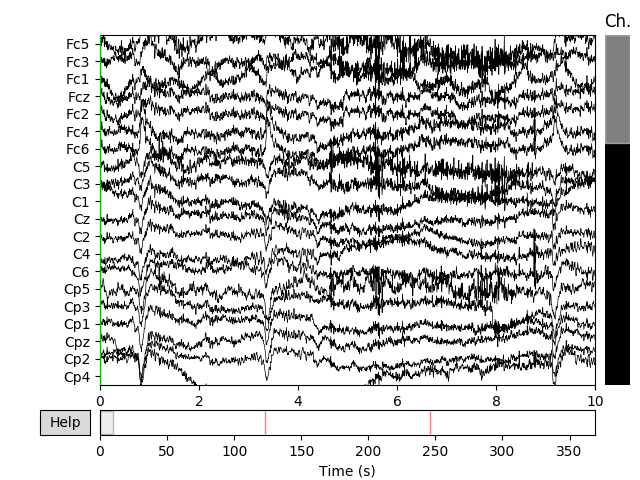

<IPython.core.display.Javascript object>


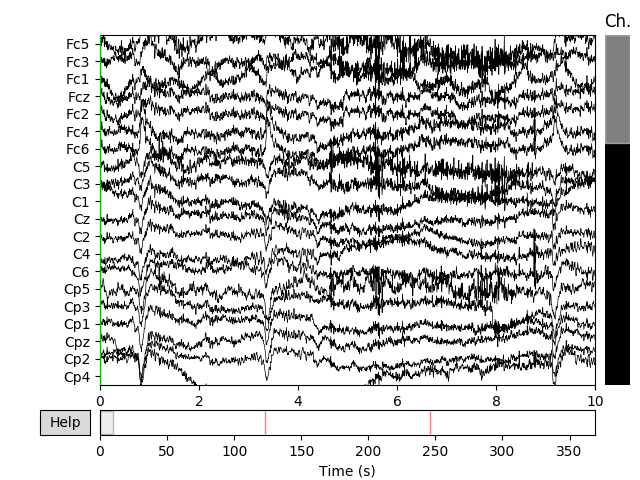

In [17]:
raw.plot()

**So let's see what this looks like when we add our events and annotations**

<IPython.core.display.Javascript object>


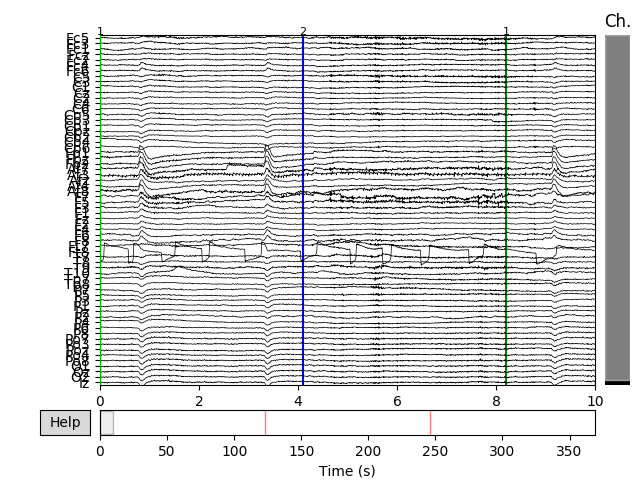

<IPython.core.display.Javascript object>


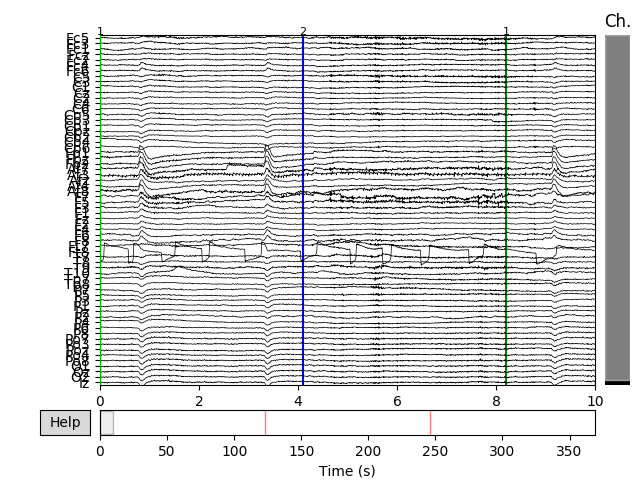

In [18]:
raw.plot(n_channels=64, scalings={"eeg": 75e-6}, events=events,
         event_color={1: "green", 2: "blue", 3: "red"})

<IPython.core.display.Javascript object>


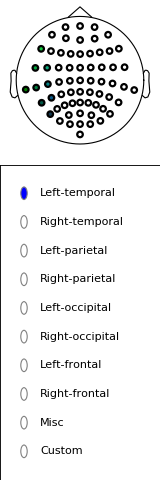

<IPython.core.display.Javascript object>


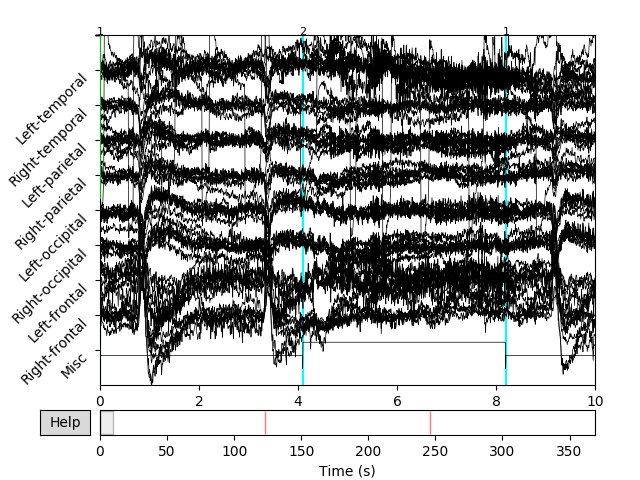

<IPython.core.display.Javascript object>


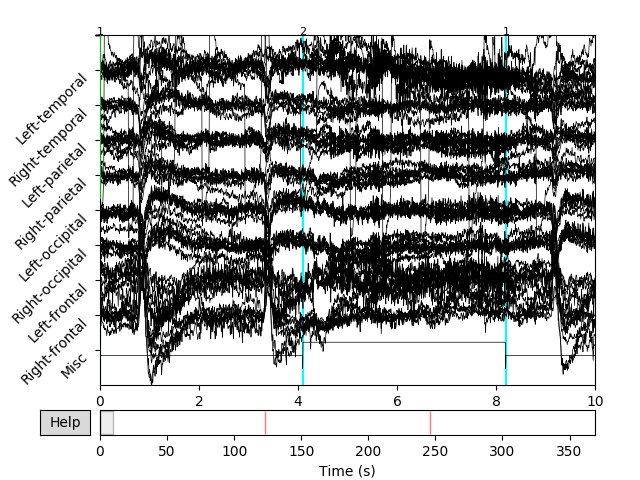

In [19]:
# Lets trying plotting in a butterfly style with our events and group them by position
raw.plot(butterfly=True, group_by='position', events=events)

**Now let's plot the power spectrum associated with all 64 channels in our data**

<IPython.core.display.Javascript object>


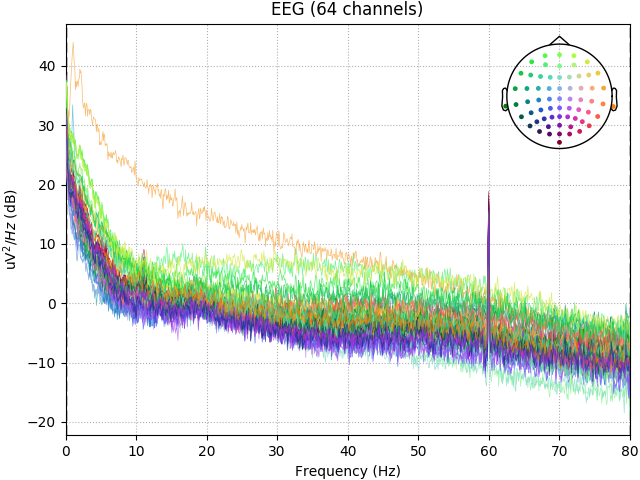

<IPython.core.display.Javascript object>


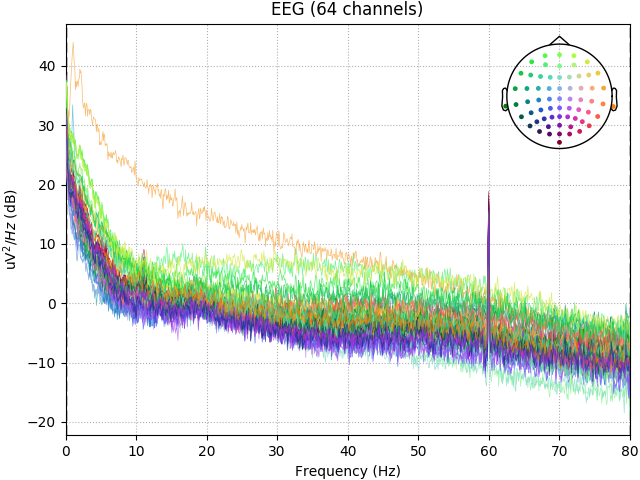

In [20]:
# Lets do some power spectrum density plots
raw.plot_psd(tmax=np.inf, average=False)

<IPython.core.display.Javascript object>


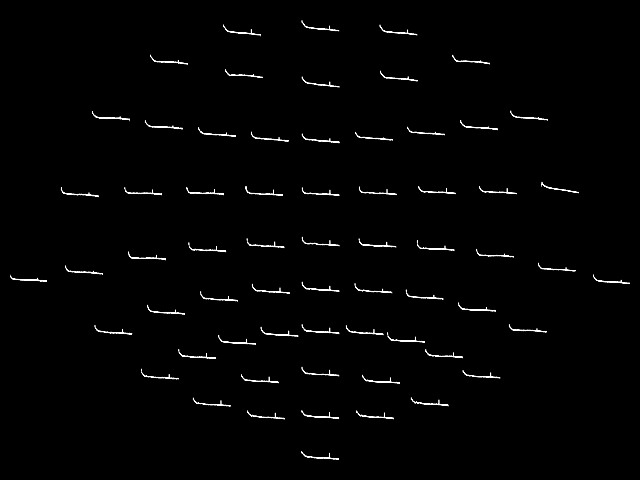

<IPython.core.display.Javascript object>


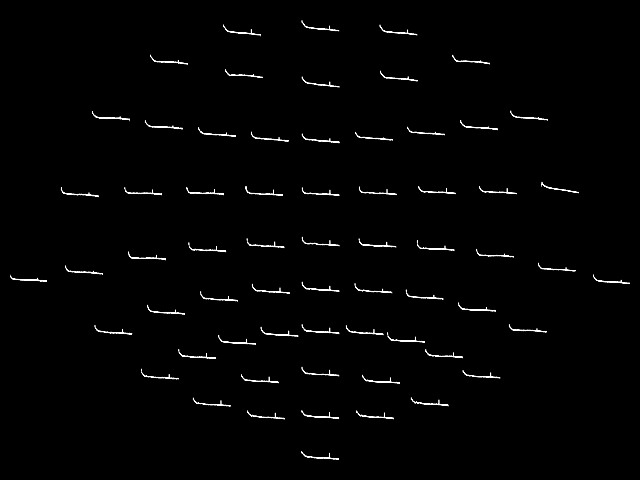

In [21]:
# Lets do a Power Spectrum Topo Plot
raw.plot_psd_topo(show=True, proj=True)

**So lets do an example of a CSP plot**

In [22]:
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in
             raw_fnames]
raw = concatenate_raws(raw_files)

In [23]:
# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

In [24]:
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events = find_events(raw, shortest_event=0, stim_channel='STI 014')

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

<IPython.core.display.Javascript object>


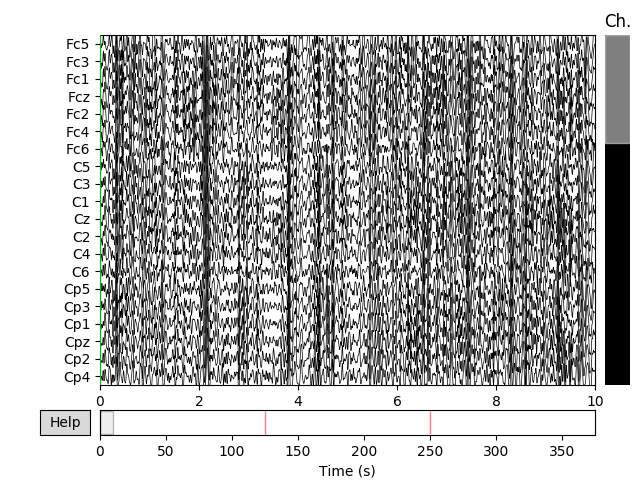

<IPython.core.display.Javascript object>


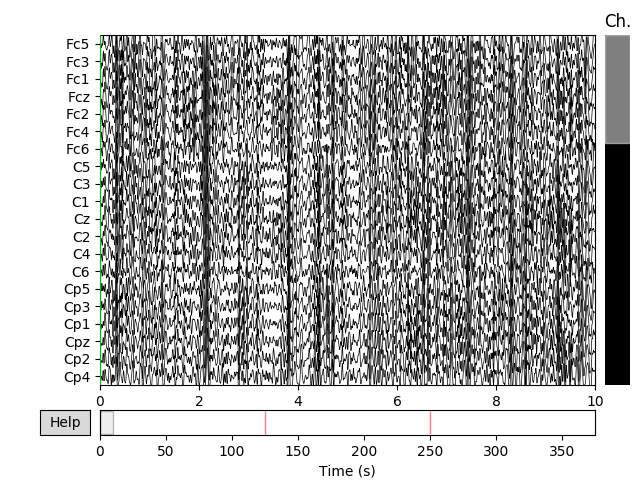

In [25]:
raw.plot()

In [26]:
# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

In [27]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

In [28]:
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

In [29]:
# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Classification accuracy: 0.933333 / Chance level: 0.533333


<IPython.core.display.Javascript object>


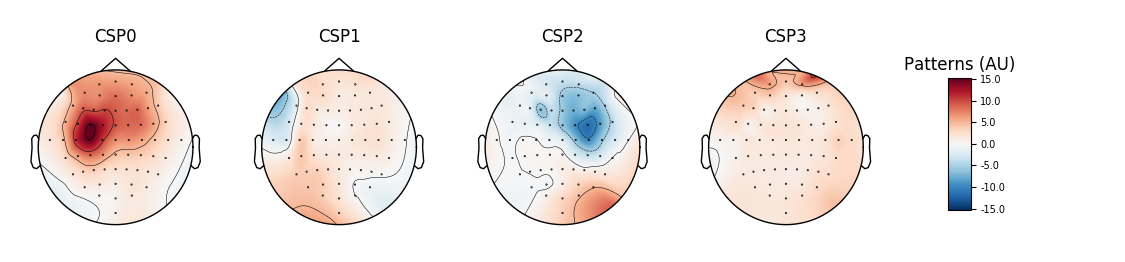

<IPython.core.display.Javascript object>


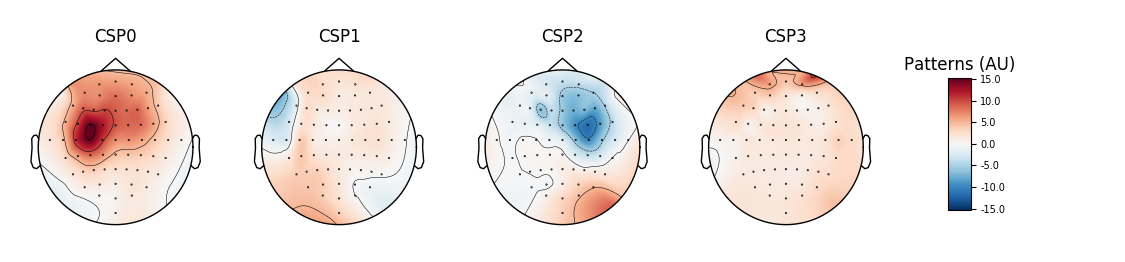

In [30]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

layout = read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

# Part 02 -- Dealing with Eye Blinks and Bad Channels

**So we're going to show you how to look at Bad EEG channels 
and correct for eye blinks within our EEG Data **

** Lets look at how to deal with eyeblinks first**


In [31]:
#Lets load up our example dataset
!wget http://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat
mat = loadmat("A01T.mat")

# So our data in this mat file is this really hard to look at dictionary
mat.keys()

# So we need to output everything from the Data key in this dictionary
# Scipy does some weird indexing with mat files
# The things we need are the calibration run and the experiment run from this dataset
# run 3 --calibration
eeg1 = mat["data"][0, 2]["X"][0, 0] * 10e-6 
# run 4 --experiment run
eeg2 = mat["data"][0, 3]["X"][0, 0] * 10e-6 

# We now need to convert these runs into raw eeg objects for mne to use them
# We need to set the number of channels to be 25
# Also we need to identify the sampling frequency as 250 Hz
# We also need to declare the channel types as the first 22 are EEG and
# the last 3 are EOG
info = mne.create_info(25, 250, ch_types=["eeg"] * 22 + ["eog"] * 3)

# We need to to transpose the arrays due to mne expecting channels in rows
# and samples in columns
raw1 = mne.io.RawArray(eeg1.T, info)
raw2 = mne.io.RawArray(eeg2.T, info)

# We need to convert the 3 monopolar EOG channels into 2 bipolar channels
# So to do this we need to multiply monopolar EOG signals with a matrix
# that generates bipolar derivations i.e. EOG1 – EOG2 and EOG3 – EOG2
bip = np.array([[1, -1, 0], [0, -1, 1]])
raw1_eog = bip @ raw1[22:, :][0]
raw2_eog = bip @ raw2[22:, :][0]

raw1_eeg = raw1[:22, :][0]
raw2_eeg = raw2[:22, :][0]


print("Raw1_EOG")
print(raw1_eog)
print("Raw2_EOG")
print(raw2_eog)
print("raw1_eeg")
print(raw1_eeg)
print("raw2_eeg")
print(raw2_eeg)

--2018-10-10 02:35:30--  http://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/001-2014/A01T.mat [following]
--2018-10-10 02:35:31--  https://lampx.tugraz.at/~bci/database/001-2014/A01T.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42806453 (41M)
Saving to: ‘A01T.mat.3’

A01T.mat.3          100%[===================>]  40.82M  1.35MB/s    in 31s     

2018-10-10 02:36:03 (1.31 MB/s) - ‘A01T.mat.3’ saved [42806453/42806453]

Raw1_EOG
[[0.00019043 0.00022461 0.00022461 ... 0.00216797 0.00233887 0.00237305]
 [0.00024902 0.00024902 0.0002832  ... 0.00053711 0.00051758 0.0

In [32]:
# The first method deals with using OLS regression

# Here we're solving for all the dependent and response variables through
# all EEG channels at the same time
# We also have several independent predictor variables coming from our EOG channels
# So we're setting up a multivariate model

# The @ symbol computes the dot product of the matrices
# np.dot can be an alternative to this
betas = np.linalg.inv(raw1_eog @ raw1_eog.T) @ raw1_eog @ raw1_eeg.T
print(betas)

# You can also do it this way as well to compute the regression coefficients
#betas = np.linalg.solve(raw1_eog @ raw1_eog.T, raw1_eog @ raw1_eog.T)

# Lets check the shape of our regresion parameter matrix
# There should be 2 EOG predictors and 22 EEG predictors
#betas.shape()

# So no we need to extract the EOG influence from our EEG data
eeg_corrected = (raw2_eeg.T - raw2_eog.T @ betas).T
raw3 = raw2.copy()
raw3._data[:22, :] = eeg_corrected

[[-0.18022469 -0.0838976  -0.10940147 -0.13093744 -0.1509659  -0.18559781
  -0.03302589 -0.06855779 -0.09018304 -0.10658396 -0.12892586 -0.14898854
  -0.18583284 -0.06929759 -0.08283364 -0.0940244  -0.10959731 -0.12236714
  -0.07615064 -0.08626461 -0.09501397 -0.07741935]
 [-0.08220462 -0.09701098 -0.06539397 -0.04303334 -0.01790982  0.01426506
  -0.08709359 -0.06212271 -0.04235793 -0.02345362 -0.00415062  0.02166974
   0.06843554 -0.0360163  -0.02533097 -0.01138205  0.00256306  0.01929797
  -0.00996135 -0.00107143  0.00927962  0.00918639]]


<IPython.core.display.Javascript object>


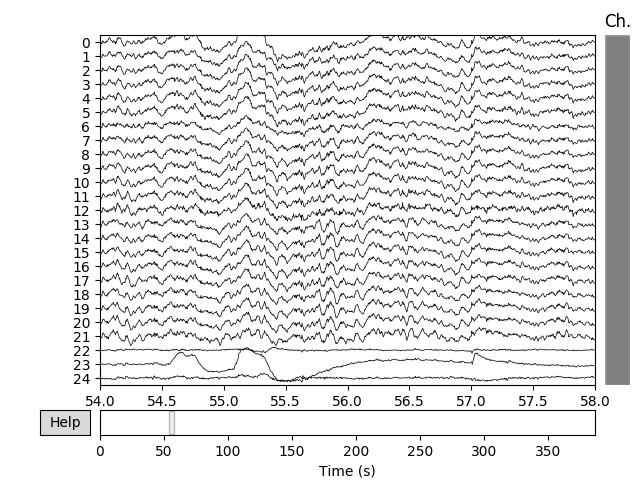

<IPython.core.display.Javascript object>


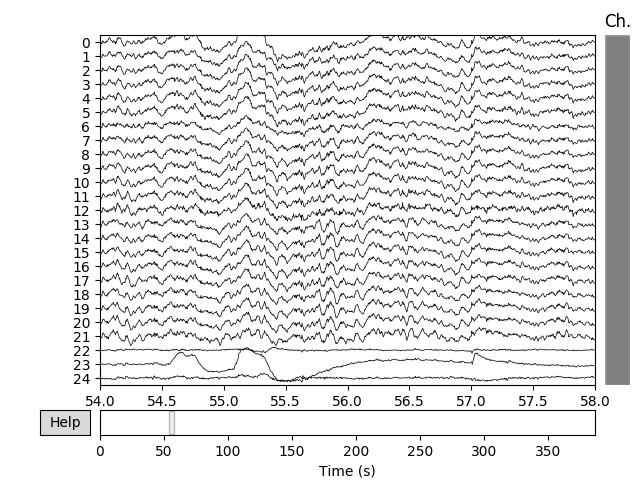

In [33]:
# So now lets look at our data before an eyeblink
raw2.plot(n_channels=25, start=54, duration=4,
          scalings=dict(eeg=250e-6, eog=750e-6))

<IPython.core.display.Javascript object>


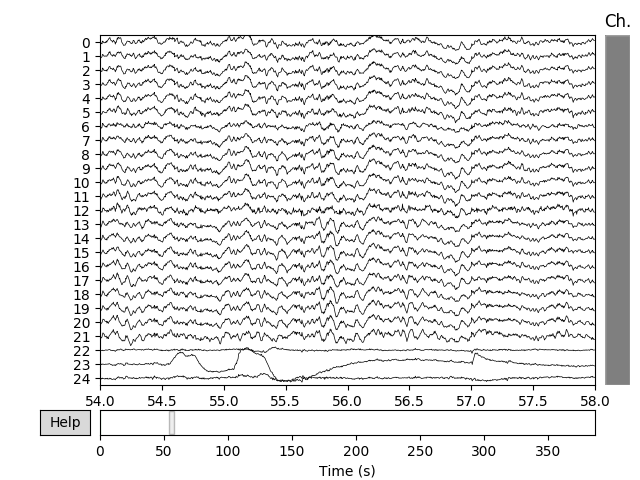

<IPython.core.display.Javascript object>


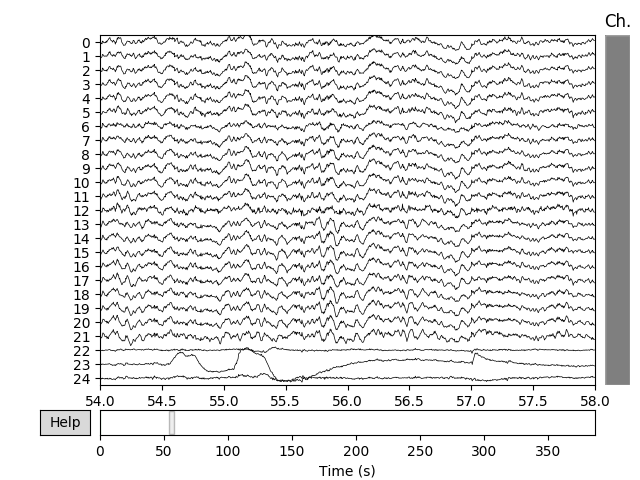

In [34]:
# Now lets look at what our data looks like after its been corrected for eye blinks
raw3.plot(n_channels=25, start=54, duration=4,
          scalings=dict(eeg=250e-6, eog=750e-6))

**Now Let's do an example of removing eye blinks in our data with ICA (Independent Components Analysis)**

In [35]:
# Let's reference our dataset and load our mat file with run 4
eeg_ica = mat["data"][0, 3]["X"][0, 0] * 10e-6

ch_names_ica = ["Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz",
            "C2", "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz",
            "P2", "POz", "EOG1", "EOG2", "EOG3"]

# We need to create an info and raw object
info_ica = mne.create_info(ch_names_ica, 250, ch_types=["eeg"] * 22 + ["eog"] * 3)
raw_ica = mne.io.RawArray(eeg_ica.T, info_ica)

raw_ica.set_montage(mne.channels.read_montage("standard_1020"))

<RawArray  |  None, n_channels x n_times : 25 x 96735 (386.9 sec), ~18.5 MB, data loaded>

In [36]:
# So ICA does not work in the presance of low frequency drifts
# So here we're going to create a copy of our raw_ica object
# and apply a high-pass filter
raw_tmp = raw_ica.copy()
raw_tmp.filter(1, None, fir_design="firwin")

# We are now going to implement ICA with the extended Infomax
# algorithm and a fixed random state that should make this more reproducible
ica = mne.preprocessing.ICA(method="extended-infomax", random_state=1)
ica.fit(raw_tmp)

<ICA  |  raw data decomposition, fit (extended-infomax): 96735 samples, 22 components, channels used: "eeg">

**So now we need to check our results and see if they worked**

<IPython.core.display.Javascript object>


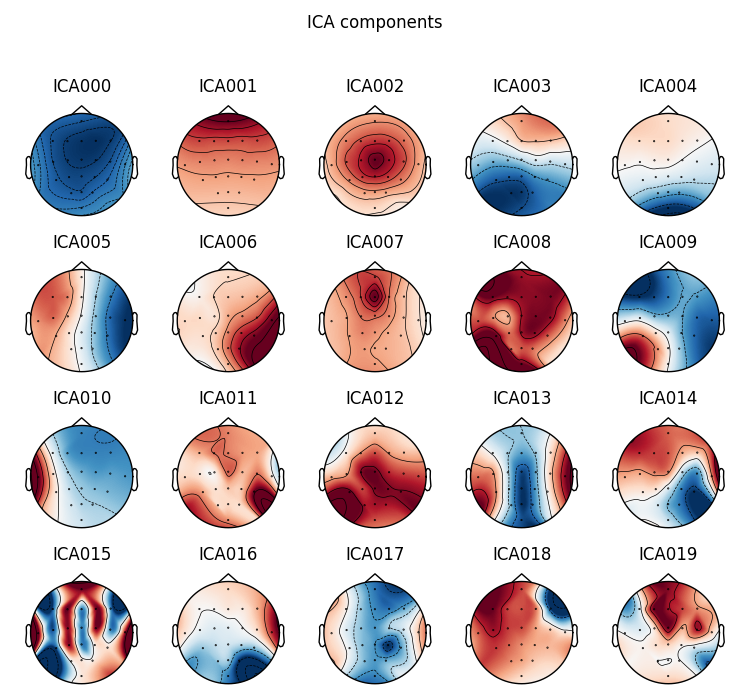

<IPython.core.display.Javascript object>


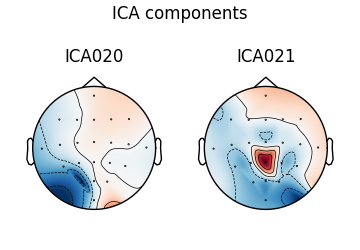

[<Figure size 750x700 with 20 Axes>, <Figure size 360x250 with 2 Axes>]

In [37]:
# We need to look at all 22 components visually
ica.plot_components(inst=raw_tmp)

<IPython.core.display.Javascript object>


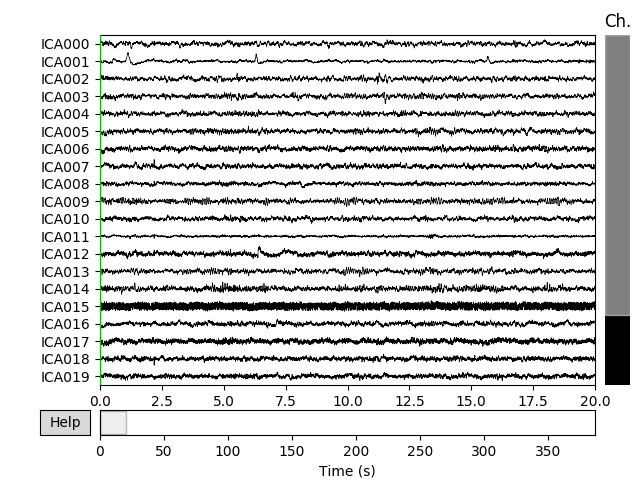

<IPython.core.display.Javascript object>


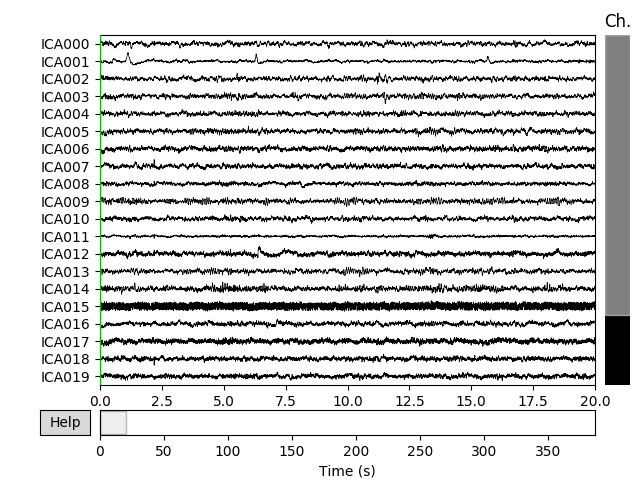

In [38]:
# So ICA001 looks like there might have an eye blink associated with it
# Lets plot out the traces to take a look
ica.plot_sources(inst=raw_tmp)

**So now let's remove the eye blinks associated with our ICA and replot it**

In [39]:
# So now we're going to create a list of the components we want to exclude
# Then we will apply ica to the corrected eeg signal
ica.exclude = [1]
raw_corrected = raw_ica.copy()
ica.apply(raw_corrected)

<RawArray  |  None, n_channels x n_times : 25 x 96735 (386.9 sec), ~18.5 MB, data loaded>

<IPython.core.display.Javascript object>


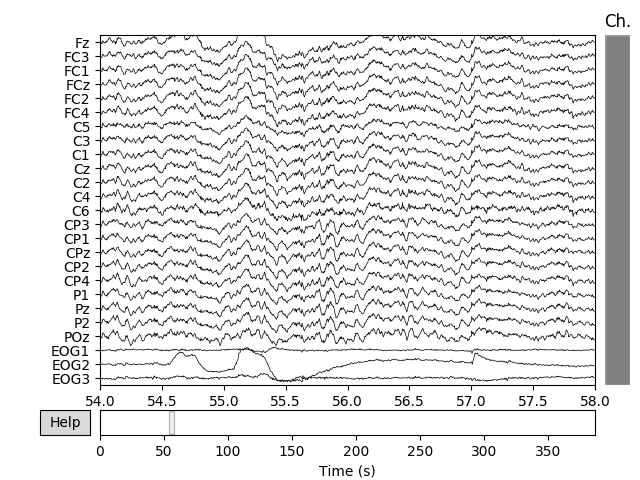

<IPython.core.display.Javascript object>


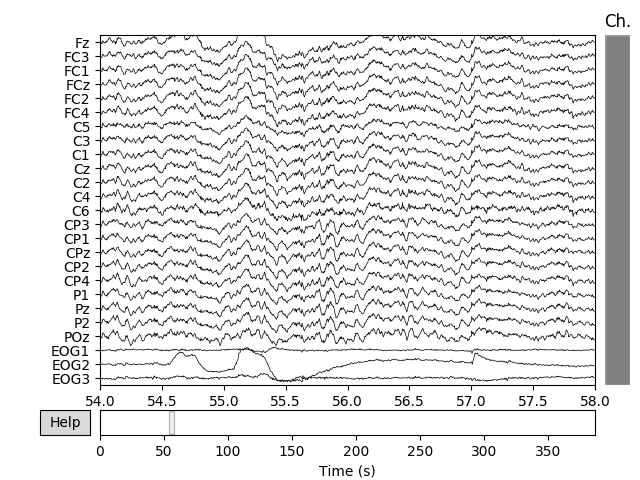

In [40]:
#Lets see what our results looked like before
# Lets plot it out again and see our results
raw_ica.plot(n_channels=25, start=54, duration=4,
         scalings=dict(eeg=250e-6, eog=750e-6))

<IPython.core.display.Javascript object>


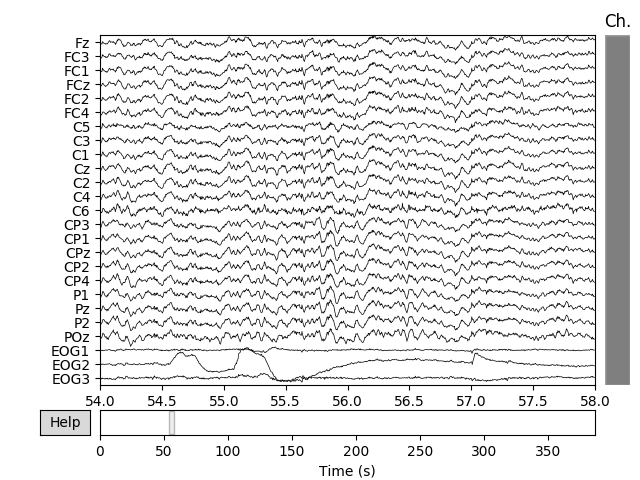

<IPython.core.display.Javascript object>


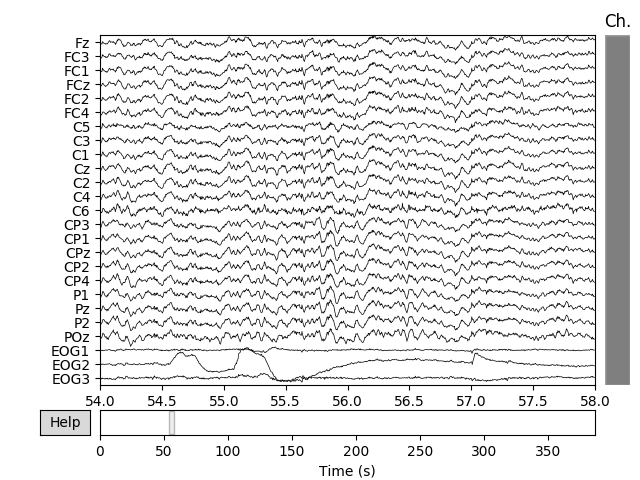

In [41]:
# This is what they looked like after
raw_corrected.plot(n_channels=25, start=54, duration=4,
                   scalings=dict(eeg=250e-6, eog=750e-6))

## Part 03 -- MEG sample data visualization

In [42]:
import os.path as op

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-43-826d5a0d5224>:12: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  evoked.plot(exclude=[], show=False)


<IPython.core.display.Javascript object>


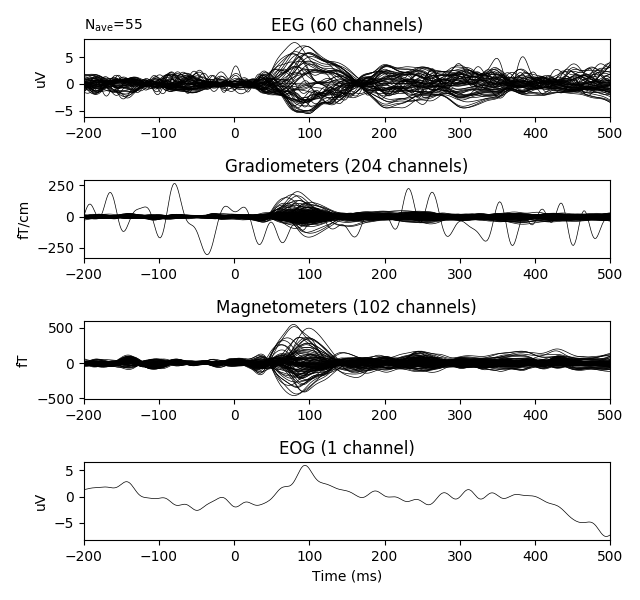

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-43-826d5a0d5224>:14: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  evoked.plot(exclude=[],show=False)


<IPython.core.display.Javascript object>


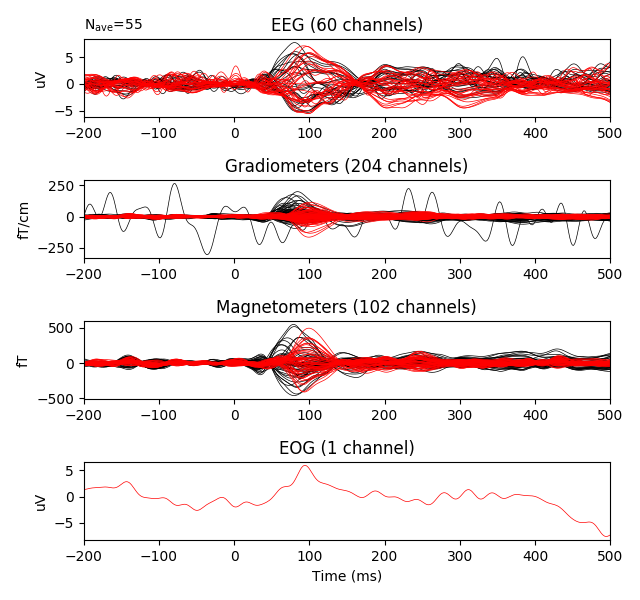

In [43]:
data_path = mne.datasets.sample.data_path()
fname = op.join(data_path, 'MEG', 'sample', 'sample_audvis-ave.fif')
evoked = mne.read_evokeds(fname, baseline=(None, 0), proj=True)

# only left aud
evoked = evoked[0]

lt_chans = [k['ch_name'] for k in evoked.info['chs']
            if k['loc'][0] <= 0 ]

evoked.info['bads'] = []
evoked.plot(exclude=[], show=False)
evoked.info['bads'] += lt_chans
evoked.plot(exclude=[],show=False)
plt.show()

## Part 04 -- Compute source space connectivity and visualize it using a circular graph

This example computes the all-to-all connectivity between 68 regions in source space based on dSPM inverse solutions and a FreeSurfer cortical parcellation. The connectivity is visualized using a circular graph which is ordered based on the locations of the regions.

In [44]:
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

In [45]:
# Load data
inverse_operator = read_inverse_operator(fname_inv)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

In [46]:
# Add a bad channel
raw.info['bads'] += ['MEG 2443']

In [47]:
# Pick MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')

In [48]:
# Define epochs for left-auditory condition
event_id, tmin, tmax = 1, -0.2, 0.5
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=dict(mag=4e-12, grad=4000e-13,
                                                    eog=150e-6))

In [49]:
# Compute inverse solution and for each epoch. By using "return_generator=True"
# stcs will be a generator object instead of a list.
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [50]:
# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('sample', parc='aparc',
                                    subjects_dir=subjects_dir)
label_colors = [label.color for label in labels]

In [51]:
# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator['src']
label_ts = mne.extract_label_time_course(stcs, labels, src, mode='mean_flip',
                                         return_generator=True)

In [52]:
# Now we are ready to compute the connectivity in the alpha band. Notice
# from the status messages, how mne-python: 1) reads an epoch from the raw
# file, 2) applies SSP and baseline correction, 3) computes the inverse to
# obtain a source estimate, 4) averages the source estimate to obtain a
# time series for each label, 5) includes the label time series in the
# connectivity computation, and then moves to the next epoch. This
# behaviour is because we are using generators and allows us to
# compute connectivity in computationally efficient manner where the amount
# of memory (RAM) needed is independent from the number of epochs.
fmin = 8.
fmax = 13.
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased']
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

In [53]:
# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c[:, :, 0]

In [54]:
# Now, we visualize the connectivity using a circular graph layout

# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

In [55]:
# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

In [56]:
# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

In [57]:
# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

In [58]:
# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

In [59]:
print (con_res[method])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.15147865  0.          0.         ...  0.          0.
   0.        ]
 [ 0.11786816  0.03655056  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.38357462  0.2445127  -0.00850612 ...  0.          0.
   0.        ]
 [ 0.0603206   0.39368231  0.02473258 ...  0.29814709  0.
   0.        ]
 [ 0.54227765  0.32399218 -0.02391454 ...  0.28035146  0.46555829
   0.        ]]


<IPython.core.display.Javascript object>


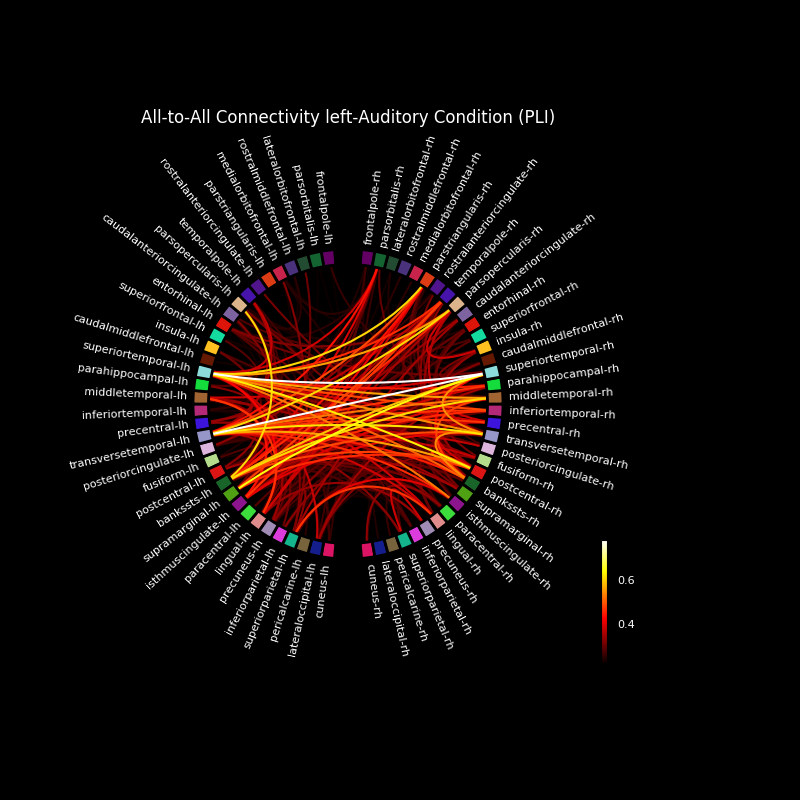

In [60]:
# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['pli'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity left-Auditory '
                               'Condition (PLI)')
#plt.savefig('circle.png', facecolor='black')
# Plot connectivity for both methods in the same plot
plt.show()

<IPython.core.display.Javascript object>


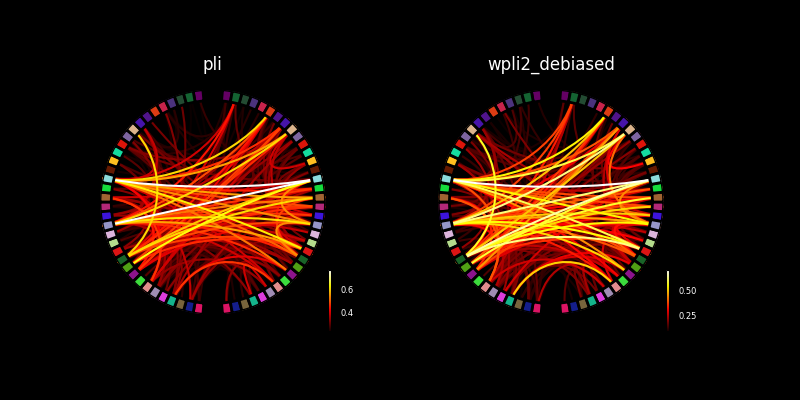

In [61]:
fig = plt.figure(num=None, figsize=(8, 4), facecolor='black')
no_names = [''] * len(label_names)
for ii, method in enumerate(con_methods):
    if set_trace:
        ipdb.set_trace()
    plot_connectivity_circle(con_res[method], no_names, n_lines=300,
                             node_angles=node_angles, node_colors=label_colors,
                             title=method, padding=0, fontsize_colorbar=6,
                             fig=fig, subplot=(1, 2, ii + 1))

plt.show()